<a href="https://colab.research.google.com/github/mshagirov/mshagirov.github.io/blob/master/_notebooks/N2V_2D_example_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combined "training" and "prediction" notebooks for Noise2Void 2D example SEM (colab version)

In [0]:
#@title Clone the n2v repository from github and install the required packages {display-mode: "form"}
#@markdown ---
#@markdown - __Run this cell to install `N2V` (Noise2Void)__
#@markdown > DON'T PANIC!
#@markdown <br> This cell will RESTART THE RUNTIME (by crashing this session).
#@markdown <br> This needs to be done to properly load `n2v`.
#@markdown - and another thing, This cell checks if you enabled hardware acceleration.
#@markdown  - if you are warned that you don't have GPU's just go to edit menu:
#@markdown <br> "Edit-->Notebook Settings-->Hardware accelaration"
#@markdown <br> and __set it to "GPU"__
#@markdown - If for some reasons you have problems with loading `n2v` or other packages:
#@markdown  - please delete n2v directory with:<br>
#@markdown  `!rm -rd n2v`
#@markdown  - after deleting `n2v`, __re-run__ this cell and re-install all requirements

import sys
import os
from tensorflow.test import is_gpu_available

def restart_runtime():
  os.kill(os.getpid(), 9)

def check_n2v():
  try:
    import n2v
    print('Imported locally installed n2v.')
  except ModuleNotFoundError:
    print("{}.\n{}".format(
        "Couldn't find n2v package, please install it before continuing to this example",
        "Go to https://github.com/juglab/n2v.git for "+
        "instructions on how to install n2v and its dependencies."))

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Check NVIDIA GPU Card
  if is_gpu_available():
    print('Available GPU\'s :\n')
    !nvidia-smi
  else:
    print('''No GPUs found!
    Before you start go to "Edit-->Notebook Settings-->Hardware accelaration" and set it to "GPU".
    ''')
  print('Notebook is running in colab.\n\t-Installing: n2v and other requirements.\n')
  print("\nDON'T PANIC! This will RESTART THE RUNTIME, by crashing the session :)\n")
  !git clone https://github.com/juglab/n2v.git
  !pip install -e ./n2v
  restart_runtime()
else:
  print('Notebook is *not* running in colab. Not installing `n2v`.')
  check_n2v()

Available GPU's :

Fri Oct 11 07:25:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    58W / 149W |     69MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GP

---

**Now**--> just continue to the examples below.

---

Fun time:
---
##### After you restart the runtime, you should be able to continue to the `N2V` examples from [juglab/n2v](https://github.com/juglab/n2v) repo (below is the 2D example, with both "training" and "prediction" notebooks copied below)

Do you want to save/import your files? Use this to mount Google drive:
```python
from google.colab import drive
drive.mount('/gdrive')
```
Google drive is now mounted in `/gdrive` folder

# Noise2Void - 2D Example for SEM data

In [2]:
#@title This cell imports all of our dependencies. You must run this cell!{display-mode: "form"}
#@markdown ---
#@markdown - imports __`n2v`__, and its components
#@markdown - also imports __`plot_history`__ from __`csbdeep.utils`__,
#@markdown - __`numpy`__, __`pyplot`__, __`urllib`__, __`os`__, __`zipfile`__
#@markdown ---
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

Using TensorFlow backend.


# Mount Your Drive and/or Download Example Data
Data by Reza Shahidi and Gaspar Jekely, Living Systems Institute, Exeter<br>
Thanks!


In [0]:
#@title Load example data (Enable/Disable){display-mode: "form"}
#@markdown ---
DOWNLOAD_DATA = True #@param {type:"boolean"}
#@markdown This data has been provided by Reza Shahidi and Gaspar Jekely,
#@markdown Living Systems Institute, Exeter
#@markdown - This cell checks whether there is a "__`./data`__" folder, and creates it if there isn't one
#@markdown - Next, it __downloads__ the data from an external server
#@markdown   if it's not already in "__`./data`__" folder
#@markdown - The data consists of two images: "train.tif" and "validation.tif"
#@markdown ---

if DOWNLOAD_DATA:
  # create a folder for our data.
  if not os.path.isdir('./data'):
      os.mkdir('./data')
  # check if data has been downloaded already
  zipPath="data/SEM.zip"
  if not os.path.exists(zipPath):
      #download and unzip data
      data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/pXgfbobntrw06lC/download', zipPath)
      with zipfile.ZipFile(zipPath, 'r') as zip_ref:
          zip_ref.extractall("data")

In [0]:
#@title Mount Google Drive (Enable/Disable){display-mode: "form"}
import sys
Mount_my_google_drive = False#@param {type:"boolean"}
IN_COLAB = 'google.colab' in sys.modules
#@markdown - If enabled, your Google Drive is mounted in "__`./gdrive`__" folder
#@markdown - In colab, use the "Files" tab on the side panel on the left to browse your files
#@markdown - or use <br>
#@markdown  __`!ls ./gdrive/`__
#@markdown  <br> __`!ls "./gdrive/My Drive"`__ (you'll need quotations if there are spaces) 
if Mount_my_google_drive and IN_COLAB:
  from google.colab import drive
  drive.mount('./gdrive')
  print('\nFiles in "./":\n---')
  !ls -la .
  print('\nFiles in "./gdrive/":\n---')
  !ls -l ./gdrive

In [76]:
# Example using "ls"
!ls .

data  gdrive  n2v  sample_data


# Training Data Preparation

For training we load __one__ set of low-SNR images and use the <code>N2V_DataGenerator</code> to extract training <code>X</code> and validation <code>X_val</code> patches.

In [72]:
#@markdown ### Loading All The '.tif' Files From The Input Directory.{display-mode: "form"}
#@markdown ---
#@markdown - First, we create the DataGenerator-object __`N2V_DataGenerator`__:
#@markdown  - `datagen = N2V_DataGenerator()`
datagen = N2V_DataGenerator()
#@markdown - It will help us load data and extract patches for training
#@markdown   and validation.
#@markdown - Then, to load the input images we use 
#@markdown   __`datagen.load_imgs_from_directory( )`__:
#@markdown   - `imgs = datagen.load_imgs_from_directory(directory = "data/")`
#@markdown - This function will return a list of images
#@markdown   (_numpy arrays_)--i.e. __our dataset__.

#@markdown ### Using your own data
#@markdown ---
#@markdown Enable/disbale changing data directory:
Change_to_my_data_ = True #@param {type:"boolean"}
data_directory = "data/"
if not os.path.isdir('./data'): print('\nCould not find "/data" folder!\n')
dims = "YX"
#@markdown Default folder for data (comes with examples) is "__`data/`__", enter the location below:
# If enabled, lines below change the input folder and "dims"
if Change_to_my_data_:
  folder_name = "/content/gdrive/My Drive/Colab Notebooks/mydatasets/" #@param ["data/"] {allow-input: true}
  #@markdown Data dimensions (_default YX, use TYX for movie stacks_):
  dims='TYX' #@param ["YX", "TYX"]
  data_directory = folder_name
print('Loading data from \n\t'+data_directory)

# If you want to load other types of files see the RGB example for n2v (github).
imgs = datagen.load_imgs_from_directory(directory = data_directory,dims=dims)

if dims=="TYX":
  print('dims=\'TYX\', re-arranging stack into single frames.')
  imgs = [elem[np.newaxis,t,...] for elem in imgs for t in range(elem.shape[0])]
print('Shapes of imgs\n',[imgs[k].shape for k in range(min(3,len(imgs)))],
      '...' if len(imgs)>3 else '', 
      '\nlen(imgs)= ',len(imgs))
#@markdown ### The loading function automatically adds two extra dimensions to the images:
#@markdown ---
#@markdown - One at the beginning, is used to hold a potential stack of images 
#@markdown   such as a movie.
#@markdown - One at the end, represents channels. <br><br>
#@markdown You can check the shape of the images with:
#@markdown - `print(imgs[0].shape,imgs[1].shape)`
#@markdown <br><br>_(Run this cell to load the images)_

Loading data from 
	/content/gdrive/My Drive/Colab Notebooks/mydatasets/
dims='TYX', re-arranging stack into single frames.
Shapes of imgs
 [(1, 512, 512, 1), (1, 512, 512, 1), (1, 512, 512, 1)] ... 
len(imgs)=  45


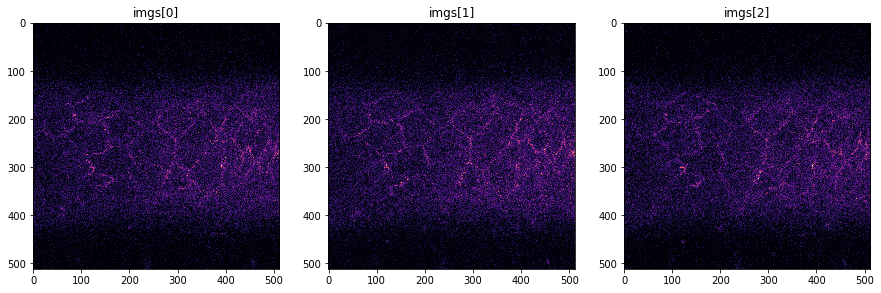

In [73]:
#@title Lets' look at the images.
#@markdown - We have to remove the added extra dimensions to display them as 2D images.
_,axs = plt.subplots(ncols=min(3,len(imgs)),figsize=[15,5])
for t in range(min(3,len(imgs))):
  axs[t].imshow(imgs[t][0,...,0], cmap='magma')
  axs[t].set_title('imgs['+str(t)+']')
plt.show()

In [69]:
#@title Generating Training and Validation datasets 
#@markdown ---
#@markdown - We will use the first image to extract training patches and store them in 'X'
X = datagen.generate_patches_from_list(imgs[:1], shape=(64,64))

#@markdown - We will use the second image to extract validation patches.
X_val = datagen.generate_patches_from_list(imgs[1:], shape=(64,64))

#@markdown - Patches are created so they do not overlap.
#@markdown  - Non-overlapping patches would also allow us to split them into a training and validation set 
#@markdown    per image.
#@markdown  - This might be an interesting alternative to the split we performed above.
#@markdown  - _(Note: this is not the case if you specify a number of patches. See the docstring for details!)_

Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64, 64, 1)
Generated patches: (392, 64,

In [0]:
#@title Just in case you don't know how to access the docstring of a method:{display-mode: "form"}
#@markdown ---
#@markdown run this command: __`datagen.generate_patches_from_list?`__
#@markdown <br><br>
#@markdown (_try running this cell to see what happens when you execute the command above_)
datagen.generate_patches_from_list?

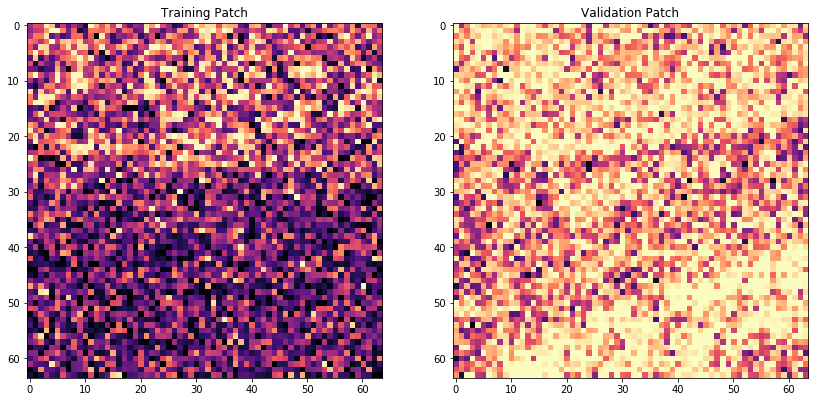

In [0]:
#@title Let's look at one of our training and validation patches.{display-mode: "form"}
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');

# Configure

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 64 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 10 and <code>train_steps_per_epoch</code> to only 10. <br>For better results we suggest values of 100, and a few dozen, respectively.

In [0]:
#@title Configure your model, set {`lr`, `input`, `loss`, ...} 
#@markdown - param-s that start with __" `n2v_` "__ define how the input pixels are perturbed
#@markdown  - E.g. `n2v_manipulator`, `n2v_neighborhood_radius`, etc.
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=10,train_epochs=10, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=1.6, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'axes': 'YXC',
 'batch_norm': True,
 'means': ['39180.418'],
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'n2v_patch_shape': (64, 64),
 'n2v_perc_pix': 1.6,
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 2,
 'probabilistic': False,
 'stds': ['18693.225'],
 'train_batch_size': 128,
 'train_checkpoint': 'weights_best.h5',
 'train_epochs': 10,
 'train_learning_rate': 0.0004,
 'train_loss': 'mse',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'train_steps_per_epoch': 10,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 32,
 'unet_residual': False}

In [0]:
#@title Create and name your model using `N2V()` {display-mode: "form"}
#@markdown ---
Over_Write = True #@param {type:"boolean"}
if Over_Write:
  try:
    model_dir_path = '{}/{}'.format(basedir,model_name)
    print(model_dir_path,' exists. Deleting it to overwrite.')
    if os.path.isdir(model_dir_path):
      !rm -dr $model_dir_path
  except NameError:
    print('Model base directory or model file name are *not* defined')


#@markdown Name your model (a name is used to identify the model)
model_name = "n2v_2D" #@param ["n2v_2D"] {allow-input: true}
#@markdown Choose the base directory in which our model will live
basedir = 'models' #@param ["models"] {allow-input: true}
# We are now creating our network model.
print('Creating network model with a given `config`')
model = N2V(config, model_name, basedir=basedir)



#@markdown <br>(This cell also __checks__ whether directory with the model already exists, and __deletes it__)<br>

Model base directory or model file name are *not* defined
Creating network model with a given `config`





# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [0]:
#@title Run tensorboard (use this cell to monitor training process){display-mode: "form"}
#@markdown ---
#@markdown Enable the Tensorboard ?
Run_Tensorboard = False #@param {type:"boolean"}

if Run_Tensorboard:
  %load_ext tensorboard
  %tensorboard --logdir=.

#@markdown <br>Use " `!ps -A|grep tensorboard` " to check its process ID (if you want to kill it)

In [0]:
#@title We are ready to start training now.
#@markdown ---
history = model.train(X, X_val)

Preparing validation data: 100%|██████████| 1456/1456 [00:05<00:00, 269.16it/s]


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 1.1254 - n2v_mse: 1.1254 - n2v_abs: 0.8554 - val_loss: 0.9055 - val_n2v_mse: 0.9055 - val_n2v_abs: 0.7582
Epoch 2/10
10/10 [==============================] - 4s 360ms/step - loss: 0.8003 - n2v_mse: 0.8003 - n2v_abs: 0.7264 - val_loss: 0.9718 - val_n2v_mse: 0.9718 - val_n2v_abs: 0.7894
Epoch 3/10
10/10 [==============================] - 6s 586ms/step - loss: 0.6946 - n2v_mse: 0.6946 - n2v_abs: 0.6749 - val_loss: 0.8873 - val_n2v_mse: 0.8873 - val_n2v_abs: 0.7380
Epoch 4/10
10/10 [==============================] - 6s 632ms/step - loss: 0.6545 - n2v_mse: 0.654

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


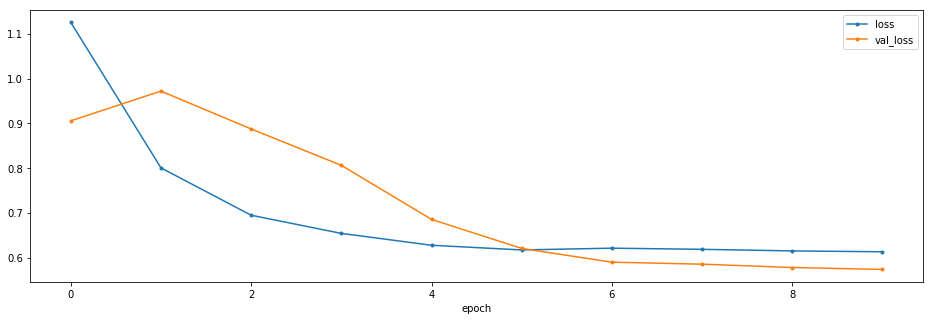

In [0]:
#@title Plotting the training and validation loss for each "step" of training process. {display-mode: "form"}
#@markdown ---
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Export Model to be Used with CSBDeep Fiji Plugins and KNIME Workflows
See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [0]:
#@title Use this command to export N2V model to be used in Fiji: {display-mode: "form"}
#@markdown ---
SAVE_FIJI = False #@param {type:"boolean"}
if SAVE_FIJI:
  model.export_TF()
#@markdown (saved in the same directory as the model, i.e. in the "__`basedir`__")
#
#@markdown ---

# Noise2Void - 2D Example for SEM data
# Prediction

In [0]:
#@title Import the dependencies (You must run this cell!) {display-mode: "form"}
#@markdown ---
#@markdown - This cell was kept after it was copied from "prediction" notebook in 
#@markdown the original N2V repository.
#@markdown - Thus, some imports are redundant,
#@markdown - this allows all the cells below to be run independently from the cells above.

# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

## Load the Network

In [0]:
#@title Load a previously trained model by creating a new N2V-object without providing a `config`.
#@markdown --- 
#@markdown > `model = N2V(` __`config=None`__ `, name=model_name, basedir=basedir)`
model_name = "n2v_2D" #@param ["n2v_2D"] {allow-input: true}
basedir = 'models' #@param ["models"] {allow-input: true}

model = N2V(config=None, name=model_name, basedir=basedir)
#@markdown - by default, this loads the weights with the lowest validation loss during training
#@markdown - To load the latest computed weights use (after executing the command above)
#@markdown > `model.load_weights('weights_last.h5')`
#@markdown - Enable/Disable loading "weights_last" below (default: __`False`__):
LOAD_weights_last = False #@param {type:"boolean"}
if LOAD_weights_last:
  model.load_weights('weights_last.h5')
# In case you do not want to load the weights that lead to lowest validation loss during 
# training but the latest computed weights, you can execute the following line:
# model.load_weights('weights_last.h5')
#@markdown ---

Loading network weights from 'weights_best.h5'.


Here we will simply use the same data as during training and denoise it using our network.

In [0]:
#@title Read the data and predict the de-noised results
#@markdown ---
#@markdown - Load the __training__ data and de-noise it:
#@markdown  - We load the data we want to process with __`imread`__
#@markdown  - (from tifffile, alter.-ly use scikit-image)
#@markdown - Then, use __`model.predict`__ to de-noise the input image(s)
#@markdown  - `model.predict` can process large images as multiple "tiles" 

input_train = imread('data/train.tif')

# Here we process the data.
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))

#@markdown - Do the same for the __validation__ data.
# We load and process the data we previously used for validation.
input_val = imread('data/validation.tif')
pred_val = model.predict(input_val, axes='YX')

100%|██████████| 2/2 [00:06<00:00,  3.18s/it]


## Show results on training data...

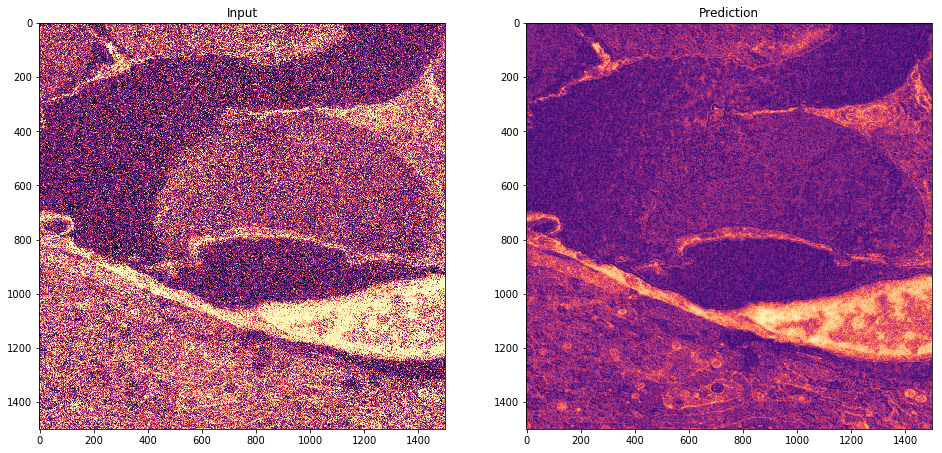

In [0]:
#@title Let's look at the "training set" results. {display-mode: "form"}
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_train[:1500:,:1500],cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_train[:1500,:1500],cmap="magma")
plt.title('Prediction');

## Show results on validation data...

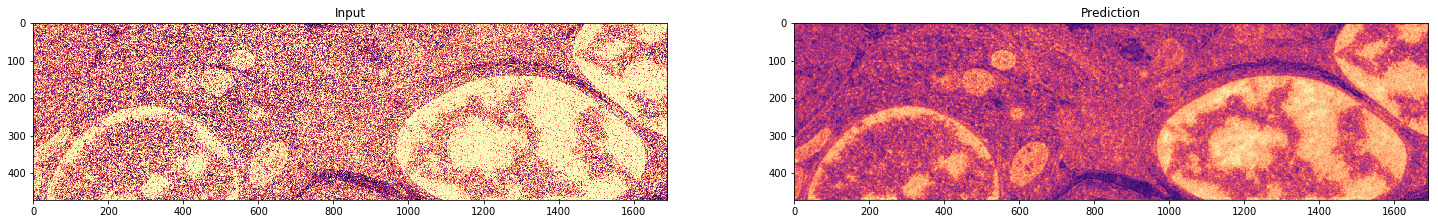

In [0]:
#@title Let's look at the "validation set" results. {display-mode: "form"}
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.imshow(input_val,cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_val,cmap="magma")
plt.title('Prediction');


## Save Results

In [0]:
save_tiff_imagej_compatible('pred_train.tif', pred_train, axes='YX')
save_tiff_imagej_compatible('pred_validation.tif', pred_val, axes='YX')